


**For coding questions, look for filling in ########## Your code here ##########; for reflection questions, write down your answers in the "Your Answer:" text block.**

There are many examples of external links to documentation. If you see reference to a `pytorch` or similar object, try hovering over the word to see if documentation is linked.

## Description:
In this homework, you will practice (1) going over the full procedure of training a neural network and (2) extending your knowledge on TF2, by implementing a transfer learning task. You will incorporate the existing [MobileNets](https://arxiv.org/abs/1704.04861) to your own network structure and to classify some new categories of images. Building and fitting the network from scratch is expensive and beyond the scope of this assignment, so you will load the MobileNets model which was pre-trained on the imagenet dataset. The version of MobileNet we're using is V2, which is a family of neural network architectures for efficient on-device image classification and related tasks.

As a general advice, you can refer to the official documentations for more info if necessary.



**Import modules for later usage.**

In [29]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

print("PyTorch version: ",torch.__version__)

PyTorch version:  2.1.1


In [30]:
if torch.cuda.is_available():
    print("GPU is available.")
else:
    print("GPU is not available.")

GPU is not available.


## **Question 1: Download and format the data**

The data we are going to use is the [Oxford flower dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/) which consists of 102 categories of flowers. Each class consists of between 40 and 258 images. The images can be found [here](https://www.robots.ox.ac.uk/~vgg/data/flowers/102/categories.html).

The main difficulty of learninig from this dataset is in the large size of the classes. You may refer to [this paper](http://www.robots.ox.ac.uk/~vgg/publications/2008/Nilsback08/) for what other researchers have done with it.

### (1) Data Pre-processing

First, load the  dataset from Kaggle (https://www.kaggle.com/competitions/oxford-102-flower-pytorch/data) where you can click "Download All" for the flower data. You can also download it directly from the zip file provided.

Then you split the data into training and testing sets. How many training and testing samples do you have?

During the pre-processing stage, we would like to format all the images for the MobileNet module.

For this module, the size of the input image is fixed to height x width = 224 x 224 pixels. The input images are expected to have 3 RGB color values in the range [0, 1], following the common image input conventions (analogously to TF 1.x).

In [31]:
# Initialize some parameters
IMG_SIZE = 224
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Define data transformations
transform = transforms.Compose([
    #do not restrain dim1 == dim2 == 224 here
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    #Custom transform to permute the dimensions
    #data is (3, dim1, dim2), we want (dim1, dim2, 3)
    #transforms.Lambda(lambda x: x.permute(1, 2, 0))
])

#Use validation set(contains labels) as a substitute for test, 
#as test set under Kaggle is hidden for submission to compete for highest accuracy


# Assuming you have PyTorch datasets, replace root=' ' with your local directory.

########## Your code here ##########
from torchvision.datasets import Flowers102

# Load the dataset
#uses the built-in datase from torch, similar to that in tf
raw_train = Flowers102(root='/Users/Johnny/Desktop/HW4', split="train", download=True)
raw_test = Flowers102(root='/Users/Johnny/Desktop/HW4', split="test", download=True)

In [32]:
#-----------------------------------------------------------
# this part is not necessary
#for nn built-in flowers


#(note that the size of the dataset does match the tf dataset)

#raw_train
print(len(raw_train))
print(len(raw_test))

# Access a specific data point (e.g., the 10th data point)
index = 10  # Change this to the index you want to access
sample_image, label = raw_train[index]

# Display the label and other information
print("nn raw data")
print(f"Data at index {index}:")
print(f"Label: {label}")
print(f"Image shape: {sample_image.size}")

# Apply the raw data transforms to raw_train and raw_test
train_nn = Flowers102(root='/Users/Johnny/Desktop/HW4', split="train", download=True, transform=transform)
test_nn = Flowers102(root='/Users/Johnny/Desktop/HW4', split="test", download=True, transform=transform)

#for nn build-in flowers: raw_train
print(len(train_nn))
print(len(test_nn))

sample_image, label = train_nn[100]
# Display the label and other information
print("nn standardized image data")
print(f"Data at index {index}:")
print(f"Label: {label}")
print(f"Image shape: {sample_image.shape}")

1020
6149
nn raw data
Data at index 10:
Label: 1
Image shape: (500, 682)
1020
6149
nn standardized image data
Data at index 10:
Label: 10
Image shape: torch.Size([3, 224, 224])


### (2) Data Exploration

Let's plot some of the data.

In [33]:
# from torch.utils.data import DataLoader, Dataset
assert isinstance(train_nn, Dataset)
assert isinstance(test_nn, Dataset)

# Print the datasets
print(train_nn)
print(test_nn)

Dataset Flowers102
    Number of datapoints: 1020
    Root location: /Users/Johnny/Desktop/HW4
    split=train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )
Dataset Flowers102
    Number of datapoints: 6149
    Root location: /Users/Johnny/Desktop/HW4
    split=test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )


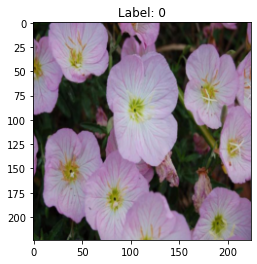

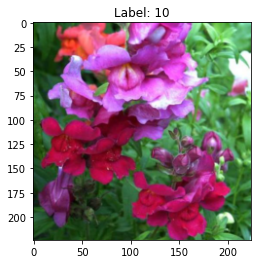

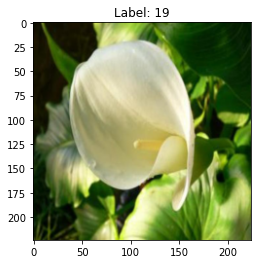

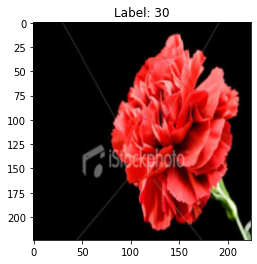

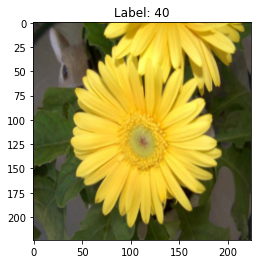

In [34]:
for i in range(5):  # Take example image 0,100,200,300,400
    index = i*100
    curr_f = train_nn[index][0]
    
    #reshape each data form (3, 224, 224) to (224, 224, 3) to plot img correctly 
    reshaped_curr_f = curr_f.permute(1, 2, 0)
    
    curr_lab = train_nn[index][1]
    plt.title("Label: %d" % curr_lab)
    plt.imshow(reshaped_curr_f)
    plt.pause(0.5)

### **Reflection Question (1a):**
In the data exploration stage, what is the purpose of "***assert isinstance(train, Dataset)***"?


**Your Answer:**

assert isinstance is an assertion statement in python. In the current example, this statement is used to determine whether the variable belongs to the Dataset class. If the judgment result is false, the program throws an AssertionError exception.

## **Part 2: Self-defined CNN**

In this section, you will define your own CNN (convolutional neural network) to classify the Oxford flowers.

Recall from the first problem, to build a neural network using `torch`, we build a class that carries out the functions of the model, define an optimizer, and iterate through a few key steps.

Here, we can make use of [`torch.nn.Sequential`](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) to save us a little hassle, now that we have seen how to build from the ground up in problem 1.

### Instructions

One suggestion is that you build a model with the following architecture, although you are free to try others as well with the same idea:

1.) Convolution with 3x3 kernel, input shape is the image shape. Make use of [`torch.nn.Conv2d`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d), followed by [`torch.nn.ReLU`](https://pytorch.org/docs/stable/generated/torch.nn.ReLU) and [`torch.nn.MaxPool2d`](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d) with `kernel_size` 2 and `stride` 2

2.) Repeat step 1 (or a couple times), being careful about input shape

3.) Convolution with 3x3 kernel, input shape is the image shape. Make use of [`torch.nn.Conv2d`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d), followed by [`torch.nn.ReLU`](https://pytorch.org/docs/stable/generated/torch.nn.ReLU) and [`torch.nn.Flatten`](https://pytorch.org/docs/stable/generated/torch.nn.Flatten)

4.) Fully connected layer using [`torch.nn.Linear`](https://pytorch.org/docs/stable/generated/torch.nn.Linear) and [`torch.nn.ReLU`](https://pytorch.org/docs/stable/generated/torch.nn.ReLU)

5.)[`torch.nn.Dropout`](https://pytorch.org/docs/stable/generated/torch.nn.Dropout)

6.) Linear layer returning us to number of classes (102)

7.) [`nothing`] or [`torch.nn.LogSoftmax`](https://pytorch.org/docs/stable/generated/torch.nn.LogSoftmax) to get label likelihood. Remember now that depending on which of these you use, you will need either [`criterion = nn.CrossEntropyLoss()`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss) or [`criterion = nn.NLLLoss()`](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss) in training. If you use `nn.CrossEntropyLoss()`, you will need the extra step of calling [`nn.functional.softmax(output, dim=1)`](https://pytorch.org/docs/stable/generated/torch.nn.functional.softmax) to compare outputs to targets in model evaluation, but not before calculating the loss in your training loop.

After fitting the model, please test the accuracy of the prediction on the test set.

In this stage, we do not ask for a great performance (you should have 'some' predictive performance though). But please ensure that you obtain a trainable model with no programming bugs. You may find it helpful to print the training progress bar or epoch.

In [35]:
# Step 1: Model definition
# Use a nn.Sequential model for deining your own CNN

########## Your code here ##########
# Define the model using nn.Sequential, naming it model

model = nn.Sequential(
    # 224*224
    nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Dropout(p=0.5),
    # 112*112
    nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Dropout(p=0.5),
    # 56*56
    nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Dropout(p=0.5),
    # 28*28
    nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(256),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Dropout(p=0.5),
    # 14*14
    nn.Flatten(),
    nn.Linear(256*14*14, 1024),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    # 1024
    nn.Linear(1024, 102),)

In [36]:
# Optional: print a summary of your model
from torchsummary import summary

# Assuming your model_transfer is defined, you can print the summary
summary(model, (3, 224, 224))  # Assuming input size is (3, 224, 224)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
       BatchNorm2d-2         [-1, 32, 224, 224]              64
              ReLU-3         [-1, 32, 224, 224]               0
         MaxPool2d-4         [-1, 32, 112, 112]               0
           Dropout-5         [-1, 32, 112, 112]               0
            Conv2d-6         [-1, 64, 112, 112]          18,496
       BatchNorm2d-7         [-1, 64, 112, 112]             128
              ReLU-8         [-1, 64, 112, 112]               0
         MaxPool2d-9           [-1, 64, 56, 56]               0
          Dropout-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 128, 56, 56]          73,856
      BatchNorm2d-12          [-1, 128, 56, 56]             256
             ReLU-13          [-1, 128, 56, 56]               0
        MaxPool2d-14          [-1, 128,

### Instructions:

Here we will prepare ourselves for training.

We need to define a few things before running our training loop, namely the `DataLoader`, `criterion`, [`optimizer`](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html), and [`lr_scheduler`](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.StepLR.html).

In [37]:
# Step 2: Model compilation
# Be sure to specify the optimizer, loss and metric as required


# Assuming you have a PyTorch model named 'model'
train_loader_nn = DataLoader(train_nn, batch_size=32, shuffle=True)


# Define your loss function, naming it 'criterion'
########## Your code here ##########
criterion = nn.CrossEntropyLoss()


# Define your optimizer, 'optimizer' (Adam is suggested)
########## Your code here ##########

optimizer = optim.Adam(model.parameters(), lr=0.001)
# Learning rate scheduler, 'lr_scheduler' (StepLR is suggested)
########## Your code here ##########

scheduler = StepLR(optimizer, step_size=10, gamma=0.5)
# Define accuracy calculation function
def accuracy(output, target):
    _, predicted = torch.max(output, 1)
    correct = (predicted == target).sum().item()
    return correct / target.size(0)

### Instructions:

Fill in necessary blanks in the training loop, with the provided guidance

In [38]:
# Step 3: Model fitting
# Use the prepared training data to fit your CNN

# Training loop
epochs = 10  # Set the number of training epochs

print("start to train")

for epoch in range(epochs):
    print("epoch " + str(epoch))
    model.train()
    total_accuracy = 0.0
    
    
    for batch in train_loader_nn:
        inputs, labels = batch
        
        # zero the gradient, calculate outputs, calculate loss,
        # backpropagate, and take a step
        #
        # this should be familiar from earlier problems in the assignment
        
        ########## YOUR CODE HERE ###########
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        outputs = nn.functional.softmax(outputs, dim=1)
        predicted_classes = outputs.argmax(dim=1)
        batch_accuracy = (predicted_classes == labels).float().mean()
        total_accuracy += batch_accuracy.item()
        
    # Calculate the average accuracy for the entire epoch
    average_accuracy = total_accuracy / len(train_loader_nn)
    
    # Take a step in learning rate with 'lr_scheduler`
    
    ############# YOUR CODE HERE ##############

    scheduler.step()
    print(f"Epoch {epoch + 1}/5, Loss: {loss.item()}, Accuracy: {average_accuracy * 100:.2f}%")
    print("len train_loader is " + str(len(train_loader_nn)))

start to train
epoch 0
Epoch 1/5, Loss: 6.056363105773926, Accuracy: 1.28%
len train_loader is 32
epoch 1
Epoch 2/5, Loss: 4.600462913513184, Accuracy: 0.89%
len train_loader is 32
epoch 2
Epoch 3/5, Loss: 4.61483097076416, Accuracy: 1.17%
len train_loader is 32
epoch 3
Epoch 4/5, Loss: 4.64169979095459, Accuracy: 1.17%
len train_loader is 32
epoch 4
Epoch 5/5, Loss: 4.562535762786865, Accuracy: 0.98%
len train_loader is 32
epoch 5
Epoch 6/5, Loss: 4.674492835998535, Accuracy: 0.98%
len train_loader is 32
epoch 6
Epoch 7/5, Loss: 4.617218971252441, Accuracy: 1.09%
len train_loader is 32
epoch 7
Epoch 8/5, Loss: 6.755532264709473, Accuracy: 0.98%
len train_loader is 32
epoch 8
Epoch 9/5, Loss: 4.613029956817627, Accuracy: 1.00%
len train_loader is 32
epoch 9
Epoch 10/5, Loss: 4.630341529846191, Accuracy: 0.78%
len train_loader is 32


In [39]:
# Step 4: Model evaluation
# Use the prepared testing data to evaluate the transfer learning model

test_dataloader_nn = DataLoader(test_nn, batch_size=32, shuffle=True)
model.cpu()
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    
    test_total_accuracy = 0.0
    
    # DataLoader object doesn't return a tuple of inputs and labels directly when you try to unpack it
    for test_batch in test_dataloader_nn:
        test_inputs, test_labels = test_batch
        test_outputs = model(test_inputs)
        test_loss = criterion(test_outputs, test_labels)       
        
        # outputs = nn.functional.softmax(outputs, dim=1) # for use if using nn.CrossEntropyLoss()
        test_predicted_classes = test_outputs.argmax(dim=1)
        test_batch_accuracy = (test_predicted_classes == test_labels).float().mean()
        test_total_accuracy += test_batch_accuracy
        
    test_average_accuracy = test_total_accuracy/len(test_dataloader_nn)
    
    print(f"Test Loss: {test_loss.item()}" + "   Test Accuracy:"
                              + str(round(test_average_accuracy.item()*100,2)) + " %")

    print("len test_loader is " + str(len(test_dataloader_nn)))

Test Loss: 4.546736240386963   Test Accuracy:0.52 %
len test_loader is 193


### **Reflection Questions:**

(1) How did you choose your network structure? \\
(2) Which optimizer did you use? Why? \\

**Your Answer:**

As for the model design, first, multiple cascaded convolution modules are used. Each module contains common structures such as convolution layers and activation functions. In order to reduce the spatial size of the feature map, I also use the MaxPooling operation.

I choose the Adam optimizer, and it is a common choice for training models. The Adam optimizer combines the advantages of AdaGrad and RMSProp.





## **Part 3: Transfer Learning Using Pre-trained Model**

There are several types of transfer learning, as illustrated [here](http://ronny.rest/blog/post_2017_10_13_tf_transfer_learning/). In this homework, you will practice B2, using MobileNet_V2.

### (1) Freeze the pre-trained model and fine-tune the transfer learning.

In [46]:
import torchvision

# Load the pre-trained MobileNetV2 model
MobileNetV2 = torchvision.models.mobilenet_v2(pretrained=True)
MobileNetV2.classifier = nn.Identity()  # Remove the classifier layers

# Set the model to evaluation mode
MobileNetV2.eval()

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

Now you can go through the same steps to build and train the transfer learning model.

### Instructions:
Within the `model_transfer = nn.Sequential()` call, dd an Adaptive Average Pooling layer with [`nn.AdaptiveAvgPool2d()`](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d), then perform flattening and apply a linear layer as you should be familiar with from earlier.

As before, remember your choice of whether to use Cross Entropy or Negative Log Likelihood, and make sure to use the corresponding output of your model (i.e., whether to apply Softmax after calculating loss or within the model)

In [49]:
# Step 1: Model definition
# Use a torch.nn Sequential model for defining the transfer learning model (B1 style)

# Set MobileNetV2 parameters to non-trainable
for param in MobileNetV2.parameters():
    param.requires_grad = False

# Use a custom reshape layer
class ReshapeLayer(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), x.size(1), 1, 1)
    
# Create a Sequential model in PyTorch
model_transfer = nn.Sequential(
    MobileNetV2,
    ReshapeLayer(),  # Reshape to [batch_size, num_channels, 1, 1]
    
########## Your code here ##########
    
    nn.AdaptiveAvgPool2d(4),
    nn.Flatten(),
    nn.Linear(1280*4*4, 102),
    
)

In [48]:
# define batch size here
batch_size = 32
input_tensor = torch.randn([batch_size, 3, 224, 224])

# visualize the model graphical structure
#Iterate through the model and print the dimensions at each layer
for layer in model_transfer:
    input_tensor = layer(input_tensor)
    print(f"Layer: {layer.__class__.__name__}, Output Shape: {input_tensor.shape}")

Layer: MobileNetV2, Output Shape: torch.Size([32, 1280])
Layer: ReshapeLayer, Output Shape: torch.Size([32, 1280, 1, 1])
Layer: AdaptiveAvgPool2d, Output Shape: torch.Size([32, 1280, 4, 4])
Layer: Flatten, Output Shape: torch.Size([32, 20480])
Layer: Linear, Output Shape: torch.Size([32, 102])


In [50]:
print(model_transfer)

Sequential(
  (0): MobileNetV2(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_size=(1, 1), s

### Instructions:

As before, write code to define your `optimizer`, `DataLoader`, `loss (criterion)`, and `lr_scheduler`.

Then, write a training loop.

Your code here should look similar to earlier in the assignment, outside of choosing hyperparameters, names, and possibly choice of loss.

In [51]:
# Step 2: Prepare for training
# Be sure to specify the optimizer, loss, DataLoader, lr_scheduler as before

########## Your code here ##########

train_loader_nn = DataLoader(train_nn, batch_size=32, shuffle=True)


criterion = nn.CrossEntropyLoss()



optimizer = optim.Adam(model_transfer.parameters(), lr=0.001)

########## Your code here ##########

scheduler = StepLR(optimizer, step_size=10, gamma=0.5)





# Training loop
epochs = 5

# Step 3: Model fitting
# Use the prepared training data to fit the transfer learning model

########## Your code here ##########



print("start to train")

for epoch in range(epochs):
    print("epoch " + str(epoch))
    
    model_transfer.train()
    total_accuracy = 0.0
    
    
    for batch in train_loader_nn:
        inputs, labels = batch
        
        # zero the gradient, calculate outputs, calculate loss,
        # backpropagate, and take a step
        #
        # this should be familiar from earlier problems in the assignment
        
        ########## YOUR CODE HERE ###########
        # print(inputs.shape)
        optimizer.zero_grad()
        outputs = model_transfer(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # Calculate accuracy for this batch
        
        outputs = nn.functional.softmax(outputs, dim=1) # for use if using nn.CrossEntropyLoss()
        predicted_classes = outputs.argmax(dim=1)
        batch_accuracy = (predicted_classes == labels).float().mean()
        total_accuracy += batch_accuracy.item()
        
    # Calculate the average accuracy for the entire epoch
    average_accuracy = total_accuracy / len(train_loader_nn)
    
    # Take a step in learning rate with 'lr_scheduler`
    
    ############# YOUR CODE HERE ##############

    scheduler.step()
    print(f"Epoch {epoch + 1}/5, Loss: {loss.item()}, Accuracy: {average_accuracy * 100:.2f}%")
    print("len train_loader is " + str(len(train_loader_nn)))



start to train
epoch 0
Epoch 1/5, Loss: 3.30220103263855, Accuracy: 16.13%
len train_loader is 32
epoch 1
Epoch 2/5, Loss: 1.0381091833114624, Accuracy: 68.29%
len train_loader is 32
epoch 2
Epoch 3/5, Loss: 0.05568278580904007, Accuracy: 89.84%
len train_loader is 32
epoch 3
Epoch 4/5, Loss: 0.07526186853647232, Accuracy: 95.40%
len train_loader is 32
epoch 4
Epoch 5/5, Loss: 0.00478902505710721, Accuracy: 97.46%
len train_loader is 32


In [52]:
# Step 3: Model evaluation
# Use the prepared testing data to evaluate the transfer learning model

test_dataloader_nn = DataLoader(test_nn, batch_size=32, shuffle=True)

print("model_transfer")
model_transfer.eval()  # Set the model to evaluation mode
with torch.no_grad():
    
    test_total_accuracy = 0.0
    
    for test_batch in test_dataloader_nn:
        test_inputs, test_labels = test_batch
        test_outputs = model_transfer(test_inputs)
        test_loss = criterion(test_outputs, test_labels)
        
        test_outputs = nn.functional.softmax(test_outputs, dim=1) # for use if you are using nn.CrossEntropyLoss()
        test_batch_accuracy = accuracy(test_outputs, test_labels)
        test_total_accuracy += test_batch_accuracy
        
    test_average_accuracy = test_total_accuracy/len(test_dataloader_nn)
    
    print(f"Test Loss: {test_loss.item()}" + "   Test Accuracy:" + str(test_average_accuracy*100) + "%")
    print("len test_loader is " + str(len(test_dataloader_nn)))

model_transfer
Test Loss: 0.19488562643527985   Test Accuracy:74.82189119170984%
len test_loader is 193


### (2) Fine-tune some parameters in your network to see if you can improve the performance on testing data. (Optional)

In [55]:
model_transfer = nn.Sequential(
    MobileNetV2,
    ReshapeLayer(), 
    nn.AdaptiveAvgPool2d(1),
    nn.Flatten(),
    nn.Linear(1280, 102),
)

batch_size = 32
input_tensor = torch.randn([batch_size, 3, 224, 224])


for layer in model_transfer:
    input_tensor = layer(input_tensor)
    print(f"Layer: {layer.__class__.__name__}, Output Shape: {input_tensor.shape}")


train_loader_nn = DataLoader(train_nn, batch_size=32, shuffle=True)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_transfer.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)
epochs = 5
print("start to train")

for epoch in range(epochs):
    print("epoch " + str(epoch))
    model_transfer.train()
    total_accuracy = 0.0
    for batch in train_loader_nn:
        inputs, labels = batch
        optimizer.zero_grad()
        outputs = model_transfer(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        outputs = nn.functional.softmax(outputs, dim=1) 
        predicted_classes = outputs.argmax(dim=1)
        batch_accuracy = (predicted_classes == labels).float().mean()
        total_accuracy += batch_accuracy.item()
        average_accuracy = total_accuracy / len(train_loader_nn)
    scheduler.step()
    print(f"Epoch {epoch + 1}/5, Loss: {loss.item()}, Accuracy: {average_accuracy * 100:.2f}%")
    print("len train_loader is " + str(len(train_loader_nn)))

test_dataloader_nn = DataLoader(test_nn, batch_size=32, shuffle=True)

print("model_transfer")
model_transfer.eval()  
with torch.no_grad():
    
    test_total_accuracy = 0.0
    
    for test_batch in test_dataloader_nn:
        test_inputs, test_labels = test_batch
        test_outputs = model_transfer(test_inputs)
        test_loss = criterion(test_outputs, test_labels)
        
        test_outputs = nn.functional.softmax(test_outputs, dim=1) 
        test_batch_accuracy = accuracy(test_outputs, test_labels)
        test_total_accuracy += test_batch_accuracy
        
    test_average_accuracy = test_total_accuracy/len(test_dataloader_nn)
    
    print(f"Test Loss: {test_loss.item()}" + "   Test Accuracy:" + str(test_average_accuracy*100) + "%")
    print("len test_loader is " + str(len(test_dataloader_nn)))

Layer: MobileNetV2, Output Shape: torch.Size([32, 1280])
Layer: ReshapeLayer, Output Shape: torch.Size([32, 1280, 1, 1])
Layer: AdaptiveAvgPool2d, Output Shape: torch.Size([32, 1280, 1, 1])
Layer: Flatten, Output Shape: torch.Size([32, 1280])
Layer: Linear, Output Shape: torch.Size([32, 102])
start to train
epoch 0
Epoch 1/5, Loss: 3.389214038848877, Accuracy: 11.75%
len train_loader is 32
epoch 1
Epoch 2/5, Loss: 1.9271191358566284, Accuracy: 68.18%
len train_loader is 32
epoch 2
Epoch 3/5, Loss: 0.9993003010749817, Accuracy: 88.95%
len train_loader is 32
epoch 3
Epoch 4/5, Loss: 0.5766781568527222, Accuracy: 96.68%
len train_loader is 32
epoch 4
Epoch 5/5, Loss: 0.5186796188354492, Accuracy: 97.94%
len train_loader is 32
model_transfer
Test Loss: 1.5357468128204346   Test Accuracy:80.6768134715026%
len test_loader is 193


### **Reflection Questions:**

(1) Briefly explain the network structure of MobileNet and how is it different from other models? \\
(2) In your experiment, which parameter(s) is the network most sensitive to? Can you briefly reason why? \\
(3) What are some pros and cons of doing transfer learning? \\
(4) What is a batch? How does the batch size affect the training process? \\
(5) What is an epoch during the training process?

1. The network structure of MobileNet is based on a series of stacked convolutional layers, each followed by batch normalization and ReLU activation functions. It uses depthwise separable convolution, which performs a separate convolution for each input channel and then combines the results. This approach reduces the number of parameters and computations required, making the model more efficient. MobileNet also includes a lightweight version of the inception module, which further enhances its efficiency. MobileNet differs from other models in its use of depthwise separable convolution and lightweight inception module. These design choices allow MobileNet to achieve better parameter efficiency and reduced computational requirements, making it suitable for deployment on resource-constrained devices. MobileNet provides a trade-off between accuracy and model size, offering a balance between computational efficiency and model performance.

2. The parameters of AdaptiveAvgPool2d have the greatest impact on the model, because this parameter will affect the input feature dimension of the fully connected layer. When the input feature dimension is too large, the model will be overfitted.

3. pro: 1). Transfer learning allows models to leverage pre-trained weights, which can significantly speed up training time and require less data. 2). Transfer learning can lead to better model performance, as pre-trained models have already learned to recognize and extract meaningful features from data. con: Transfer learning may not be suitable for tasks that require domain-specific features or significantly different representations from the pre-trained model.

4. A batch is a subset of the training data used to train a machine learning model. The batch size refers to the number of samples in each batch. The batch size affects the training process in several ways: 1). Larger batch sizes can make better use of parallel processing capabilities, leading to faster training times on hardware with sufficient memory. 2). Smaller batch sizes introduce more noise into the gradient estimation, which can act as a regularizer and help prevent overfitting. However, very small batch sizes may increase training instability. 3). Larger batch sizes tend to converge to sharper minima, while smaller batch sizes may converge to flatter minima, which can generalize better but may also lead to slower convergence.

5. An epoch during the training process refers to a single pass through the entire training dataset. In each epoch, the model processes all the training examples once and updates its weights based on the calculated gradients. The number of epochs determines how many times the model sees the entire dataset during training. Increasing the number of epochs can help the model learn more complex patterns, but it may also lead to overfitting if the model starts memorizing the training data instead of generalizing from it.

**Your Answer:**




(2) Describe any observation you find interesting from the above experiment (Open-ended).

**Your Answer:**




What surprises me most is that transfer learning can greatly improve the performance of the model. In the future, I will learn more about transfer learning and compare the impact of different transfer strategies on the results.